# Линейно-квадратичный регулятор

Рассмотрим линейную стационарную систему дифференциальных уравнений 

$$  \dot{ \mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B}\mathbf{u}, \quad \mathbf{x} \in \mathbb{R}^n , \quad \mathbf{u} \in \mathbb{R}^m$$
где 
$\mathbf{A}_{n \times n}$, $\mathbf{B}_{n\times m}$ - матрицы с постоянными коэффициентами  
$\mathbf{x}$  - вектор состояния  
$\mathbf{u}$ - вектор управляющих параметров 
   

Цель: найти управление $\mathbf{u}(t)$, минимизирующее следующий функционал  

$$ J = \frac{1}{2}\int_{0}^{\infty} \mathbf{x}^T(t) \mathbf{Q} \mathbf{x}(t) + \mathbf{u}(t)^T \mathbf{R} \mathbf{u}(t) dt $$  
где 
$\mathbf{Q}, \mathbf{R}$ - положительно определенные матрицы 

In [1]:
import numpy as np
import scipy as sci
from scipy.integrate import solve_ivp 
import matplotlib.pyplot as plt

In [2]:
# решение алгебраического уравнения Риккати
def lqr_fun(A, B, Q, R):
    P = np.matrix(sci.linalg.solve_continuous_are(A, B, Q, R))
 
    K = -np.matrix(sci.linalg.inv(R) * (B.T * P))
 
    eigVals, eigVecs = sci.linalg.eig(A + B * K)
 
    return K, P, eigVals

# Уравнения относительного движения КА

Рассматривается движение КА по круговой орбите в центральном гравитационном поле Земли. Уравнения движения КА, летящего по близкой орбите могут быть получены линеаризацией его полных уравнений движения в орбитальной системе координат, связанной с движением первого КА. 

Уравнения относительного движения

$$
\begin{equation}\label{eq:HCW_eq}
    \begin{cases}
        \ddot x +2n \dot z =  u_x, \\
        \ddot y + n^2 y =  u_y, \\
        \ddot z - 2n \dot x - 3n^2 z  =  u_z,
    \end{cases},
\end{equation}
$$
где $u$ - управляющие воздействия.

Явный вид матриц $\mathbf{А}$ и $\mathbf{B}$.  

$$
\begin{equation*}
A =  
\begin{pmatrix}
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0 & -2n\\
0 & -n^2 & 0 & 0 & 0 & 0\\
0 & 0 & 3 n^2 & 2n & 0 & 0
\end{pmatrix},
\quad
B =  
\begin{pmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{pmatrix}
\end{equation*}
$$


### Пример решения задачи о приведении КА на одно из решений, выбранных в качестве целевой траектории

Сначала зададим параметры орбиты, а также матрицы A и B:

In [3]:
class Parameters(object):
    pass

cnst = Parameters()
cnst.mu = 3.986e14
cnst.Rer = 6371e3

orbit = Parameters
orbit.altitude = 700000
orbit.R = orbit.altitude + cnst.Rer
orbit.n = np.sqrt(cnst.mu / orbit.R**3)
orbit.T = 2 * np.pi / orbit.n

hcw = Parameters()
hcw.A = np.matrix([[0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 1., 0.],
                   [0., 0., 0., 0., 0., 1.],
                   [0., 0., 0., 0., 0., -2. * orbit.n],
                   [0., -orbit.n**2, 0., 0., 0., 0.],
                   [0., 0., 3. * orbit.n**2, 2.*orbit.n, 0., 0.]])
hcw.B = np.concatenate((np.zeros((3, 3)), np.eye(3)), 0)

lqr = Parameters()
lqr.Q = np.eye(6) * 1e-10
lqr.R = np.eye(3)
lqr.K, P, E = lqr_fun(hcw.A, hcw.B, lqr.Q, lqr.R)

Определим целевую траекторию движения КА-chaser по известным уравнениям:

In [4]:
C1 = 1000
C2 = 1000

def ref_traj(t):
    x_r = C1 * np.cos(orbit.n * t)
    y_r = C2 * np.sin(orbit.n * t)
    z_r = 0.5 * C1 * np.sin(orbit.n * t)
    vx_r = - orbit.n * C1 * np.sin(orbit.n * t)
    vy_r = orbit.n * C2 * np.cos(orbit.n * t)
    vz_r = 0.5 * orbit.n * C1 * np.cos(orbit.n * t)
    return np.array([x_r, y_r, z_r, vx_r, vy_r, vz_r])

def rhs(t, x):   
    x_err = x - ref_traj(t)
    return np.array((hcw.A.dot(x) + (hcw.B.dot(lqr.K)).dot(x_err)))[0]

In [5]:
x0 = [500., 500., 0., 0., 0., 0.]
#x0 = ref_traj(0)
t_sol = np.arange(0, orbit.T, 1)

sol = solve_ivp(rhs, (0, orbit.T), x0, t_eval = t_sol)

Построим эти траектории. Синяя - текущая траектория КА, красная - целевая:

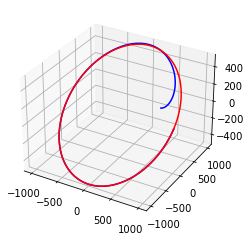

In [6]:
x_sol = sol.y
x_ref = ref_traj(t_sol)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_sol[0, :], x_sol[1, :], x_sol[2, :], 'b', label='parametric curve')
ax.plot(x_ref[0, :], x_ref[1, :], x_ref[2, :], 'r', label='parametric curve')


## State-Dependent Riccati Equation

Рассматривается система управления, модель которой представляется в виде
$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}) + \mathbf{B}(\mathbf{x}) \cdot \mathbf{u}, \quad \mathbf{x} \in \mathbb{R}^n, \quad u \in \mathbb{R}^m$$

$\mathbf{x} = 0$ - равновесие, то есть $\mathbf{f}(0) = 0$.


Цель: найти управление $\mathbf{u}(t)$, минимизирующее функционал  

$$ J = \frac{1}{2}\int_{0}^{\infty} \mathbf{x}^T(t) \mathbf{Q}(x) \mathbf{x}(t) + \mathbf{u}(t)^T \mathbf{R}(x) \mathbf{u}(t) dt $$  
где 
$\mathbf{Q} \geq 0, \mathbf{R}>0$ .

Закон управления ищется в виде
$$\mathbf{u}(t) = \mathbf{k}(\mathbf{x}) = -\mathbf{K(\mathbf{x})}\mathbf{x}, \quad \mathbf{k}(0)=0.$$

Можно показать, что при условии $\mathbf{f}(0) = 0$ и $\mathbf(f) \in C^1(\mathbb{R}^n)$ всегда найдётся такая $\mathbf{A}(\mathbf{x})$, что

$$\mathbf{f}(\mathbf{x}) = \mathbf{A}(\mathbf{x})\cdot \mathbf{x}$$

Таким образом, исходая система может быть записана в виде:

$$\dot{\mathbf{x}} = \mathbf{A}(\mathbf{x})\cdot \mathbf{x} + \mathbf{B}(\mathbf{x}) \cdot \mathbf{u},$$
эти уравнения имеют линейную структуру, но матрицы $\mathbf{A}$ и $\mathbf{B}$ завистя от вектора состояния $\mathbf{x}$. В литературе такое представление называют SDC (state-dependent components).

Применение к такой "обобщённо-линейной" системе методов управления линейными системами приводит к нахождению законов управления вида $\mathbf{u}(t) = -\mathbf{K(\mathbf{x})}\mathbf{x}$, что даёт матрицу системы с отрицательной обратной связью вида
$$\mathbf{A}_{CL}(\mathbf{x}) = \mathbf{A}(\mathbf{x}) - \mathbf{B}(\mathbf{x})\mathbf{K}(\mathbf{x}),$$
которая должна быть гурвицевой в каждой точке.

#### SDRE

применяя к системе алгоритм для задачи о линейно-квадратичном регуляторе, получим:

$$\mathbf{u}(t) = \mathbf{R}^{-1}(\mathbf{x})\mathbf{B}^{T}(\mathbf{x})\mathbf{P}(\mathbf{x})\cdot \mathbf{x},$$

где $\mathbf{P}(\mathbf{x})$ - определённое единственным образом, симметрическое решение уравнения Риккати с коэффициентами, зависящими от вектора состояния:

$$\mathbf{P}(\mathbf{x})\mathbf{A}(\mathbf{x}) + \mathbf{A}^T(\mathbf{x})\mathbf{P}(\mathbf{x})-\mathbf{P}(\mathbf{x})\mathbf{B}(\mathbf{x})\mathbf{R}^{-1}(\mathbf{x})\mathbf{B}^T(\mathbf{x})\mathbf{P}(\mathbf{x})+\mathbf{Q}(\mathbf{x})=0$$

### Пример

Рассмотрим систему
$$\left\{ 
\begin{array}\\
\dot{x}_1 = x_1 x_2 \\
\dot{x}_2=-x_2 + u
\end{array}
\right.$$

1. Метод функция Ляпунова даёт
$$ V = \frac{x_1^2 e^{2x_2}+x_2^2}{2} \qquad u_L = \frac{x_2^2 - \sqrt{x_2^4 +(x_1^2 e^{2x_2}+x_2^2)^4}}{x_1^2 e^{2x_2}+x_2}$$

2. Метод синтеза регуляторов в каскадных системах управления
$$u_{BS} = (1-\lambda)x_2 - (1 + \lambda)x_1^2 - 2x_1^2 x_2, \quad \lambda > 0$$

3. Для SDRE
$$\mathbf{Q}(\mathbf{x}) = 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}, \quad \mathbf{R}(\mathbf{x}) = 1.$$

$$\mathbf{A}(\mathbf{x}) = 
\begin{pmatrix}
0 & x_1 \\
0 & -1
\end{pmatrix}, \quad 
\mathbf{B}(\mathbf{x}) = 
\begin{pmatrix}
0 \\ 1
\end{pmatrix}.$$


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 

Text(0.5, 0, '$x_1$')

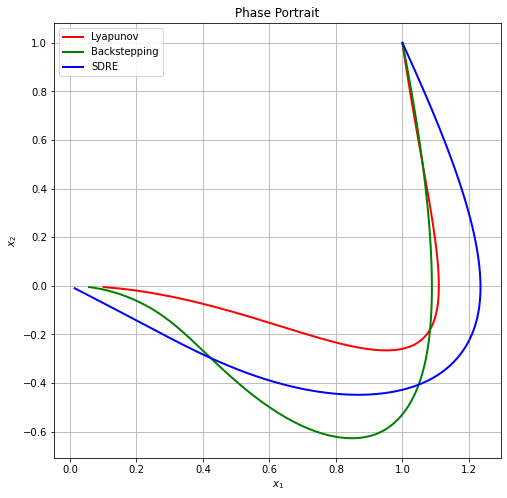

In [8]:
def u_lyapunov(x):
    v = x[0]**2 * np.exp(2 * x[1]) + x[1]**2
    original_u = x[1]**2 - np.sqrt(x[1]**4 + v**4) / (x[0]**2 * np.exp(2 * x[1]) + x[1])
    reasonable_u = -x[0]**2 * np.exp(2 * x[1]) - x[1]
    return reasonable_u

def u_backstep(x):
    lmbda = 2
    return (1 - lmbda) * x[1] - (1 + lmbda) * x[0]**2 - 2 * x[0]**2 * x[1]

def u_sdre(x):
    A = np.array([[0, x[0]], [0, -1]])
    B = np.array([[0], [1]])
    Q = np.eye(2)
    R = np.eye(1)
    K, _, _ = lqr_fun(A, B, Q, R)
    return np.dot(K, x).item()

def rhs_lyapunov(t, x):
    return np.array([ x[0]  * x[1], -x[1] + u_lyapunov(x) ])

def rhs_backstep(t, x):
    return np.array([ x[0]  * x[1], -x[1] + u_backstep(x) ])

def rhs_sdre(t, x):
    return np.array([ x[0]  * x[1], -x[1] + u_sdre(x) ])

t0 = 0
tf = 100
t_span = np.arange(t0, tf, 0.01)
x0 = np.array([1, 1])

sol_lyapunov = solve_ivp(rhs_lyapunov, (t0, tf), x0, t_eval = t_span )
x_lyapunov = sol_lyapunov.y.T

sol_backstep = solve_ivp(rhs_backstep, (t0, tf), x0, t_eval = t_span )
x_backstep = sol_backstep.y.T

sol_sdre = solve_ivp(rhs_sdre, (t0, tf), x0, t_eval = t_span )
x_sdre = sol_sdre.y.T

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_title("Phase Portrait")
ax1.grid(True)
ax1.plot(x_lyapunov[:, 0], x_lyapunov[:, 1], color='red', label = 'Lyapunov', linewidth = 2)
ax1.plot(x_backstep[:, 0], x_backstep[:, 1], color='green', label = 'Backstepping', linewidth = 2)
ax1.plot(x_sdre[:, 0], x_sdre[:, 1], color='blue', label = 'SDRE', linewidth = 2)

ax1.legend()
ax1.set_ylabel(r'$x_2$')
ax1.set_xlabel(r'$x_1$')